## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [1]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [2]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [3]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [4]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$ K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [5]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [6]:
### YOUR ANSWER HERE
temps = np.arange(3000, 10001, 1000)
Bmag = stellar_magnitude(temps, 'B')
Vmag = stellar_magnitude(temps, 'V')
B_V = Bmag - Vmag

for temp, BV in zip(temps, B_V):
    print(f"For {temp}K, the B-V color is {BV:.2f}")

For 3000K, the B-V color is 1.08
For 4000K, the B-V color is 0.48
For 5000K, the B-V color is 0.13
For 6000K, the B-V color is -0.10
For 7000K, the B-V color is -0.26
For 8000K, the B-V color is -0.38
For 9000K, the B-V color is -0.47
For 10000K, the B-V color is -0.54


### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [7]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [8]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance


### YOUR ANSWER HERE
def model(temp: float | int, Av: float | int, 
          dist: float | int, filter: str):
    """
    Model apparent magnitude given temperature (K), extinction, and distance (pc)
    m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
    """
    absmag = stellar_magnitude(temp, filter)
    extinction = Av * filters[filter]['R_lambda']
    return absmag + 5 * np.log10(dist/10) + extinction

def chisq(theta, filter_names, mag_obs, mag_err):
    temp, Av, dist = theta
    if not isinstance(filter_names, np.ndarray):
        filter_names = np.array(filter_names)
    mag_model = np.array([model(temp, Av, dist, filter) for filter in filter_names])
    chisq = np.sum(((mag_obs - mag_model) / mag_err)**2)
    return chisq

def LL(theta, filter_names, mag_obs, mag_err):
    temp, Av, dist = theta
    if not isinstance(filter_names, np.ndarray):
        filter_names = np.array(filter_names)
    mag_model = np.array([model(temp, Av, dist, filter) for filter in filter_names])
    chisq = np.sum(((mag_obs - mag_model) / mag_err)**2)
    return 0.5 * (chisq + np.sum(np.log(2 * np.pi * mag_err**2)))

mag_obs = np.array([synthetic_star[filter]['magnitude'] for filter in filter_names])
mag_err = np.array([synthetic_star[filter]['error'] for filter in filter_names])

res = minimize(
    LL,
    initial_guess,
    args=(filter_names, mag_obs, mag_err),
)

print(f"Optimize succeeded: {res.success}")

temp_fit, Av_fit, dist_fit = res.x

chi2 = chisq([temp_fit, Av_fit, dist_fit], filter_names, mag_obs, mag_err)
red_chi2 = chi2 / (len(mag_obs) - len(res.x))

print(f"Best-fit parameters:\n\
    Temperature = {temp_fit:.3f} K\n\
    Av = {Av_fit:.3f} mag\n\
    Distance = {dist_fit:.3f} pc\n\
    Red chi2 = {red_chi2:.3f}")


Optimize succeeded: True
Best-fit parameters:
    Temperature = 7638.261 K
    Av = 0.942 mag
    Distance = 111.825 pc
    Red chi2 = 0.827


In [9]:
# Asked ChatGPT for which library best to use Hessian
from numdifftools import Hessian
func = lambda t: LL(t, filter_names, mag_obs, mag_err)
H = Hessian(func)(res.x)
cov = np.linalg.inv(H)
error = np.sqrt(np.diag(cov))
corr = cov / np.outer(error, error)

print(f"Inverse Hessian Matrix\n{corr}\n")
print(f"Uncertainties:\n\
    Temp_err = {error[0]}\n\
    Av_err = {error[1]}\n\
    Dist_err = {error[2]}")

Inverse Hessian Matrix
[[1.         0.9978079  0.98879782]
 [0.9978079  1.         0.97734001]
 [0.98879782 0.97734001 1.        ]]

Uncertainties:
    Temp_err = 1655.6350105304753
    Av_err = 0.18285113377263842
    Dist_err = 13.98497559222005


Based on the correlation matrix, all parameters correlated strongly.

### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [10]:
### YOUR ANSWER HERE
N = 1000
results = np.zeros((N, 3))
success = np.zeros(N, dtype=bool)

# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance

for k in range(N):
    # independent RNG per star
    r = np.random.seed(np.random.randint(0, 2**32 - 1))

    # 1000 stars with different random seeds
    mag_obs = np.array([synthetic_star[filter]['magnitude'] for filter in filter_names])
    mag_err = np.array([synthetic_star[filter]['error'] for filter in filter_names])
    mag_obs += np.random.normal(0, mag_err)

    res = minimize(
        LL,
        initial_guess,
        args=(filter_names, mag_obs, mag_err),
    )
    results[k] = res.x
    success[k] = res.success
    
print(f"Fits succeeded: {success.sum()} / {N}")

# keep only successful fits
fits_success = results[success]

mean = fits_success.mean(axis=0)
std = fits_success.std(axis=0)
bias = mean - np.array([TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE])

print(f"Best-fit parameters with uncertainties:\n\
    Temperature = {mean[0]:.3f} +/- {std[0]:.3f} K\n\
    Av = {mean[1]:.3f} +/- {std[1]:.3f} mag\n\
    Distance = {mean[2]:.3f} +/- {std[2]:.3f} pc\n")

print(f"Bias: {bias}")

Fits succeeded: 72 / 1000
Best-fit parameters with uncertainties:
    Temperature = 8172.100 +/- 2494.116 K
    Av = 0.937 +/- 0.199 mag
    Distance = 114.976 +/- 19.014 pc

Bias: [1.67210031e+03 1.36641150e-01 1.49756192e+01]


### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

100%|██████████| 5000/5000 [00:04<00:00, 1110.95it/s]


All filters
Best MCMC Parameters:
Temperature (K) = 6404.217 +521.717/-560.818
Av (mag) = 0.778 +0.084/-0.103
Distance (pc) = 100.478 +4.785/-4.889


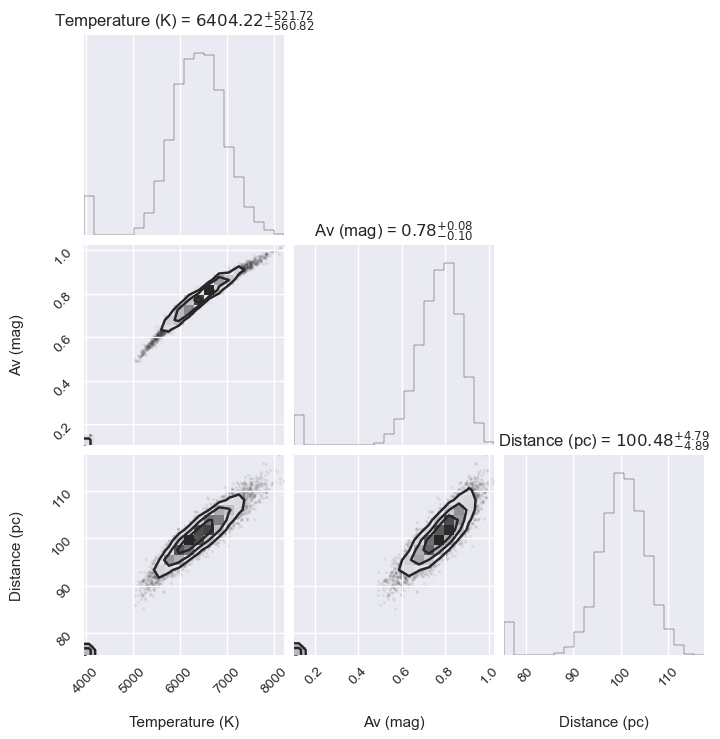

100%|██████████| 5000/5000 [00:03<00:00, 1358.01it/s]


RIJHK filters
Best MCMC Parameters:
Temperature (K) = 6352.555 +551.656/-504.461
Av (mag) = 0.784 +0.087/-0.095
Distance (pc) = 99.687 +5.081/-5.013


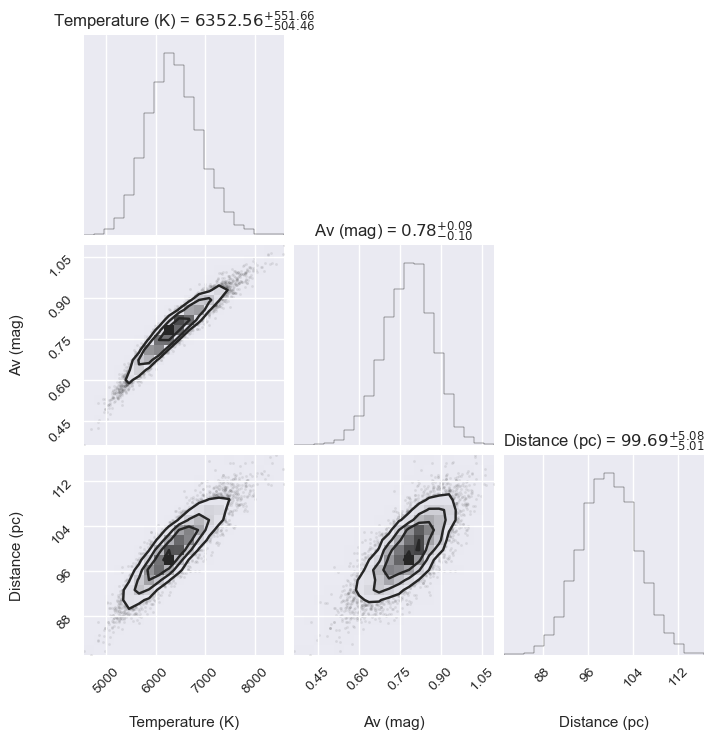

100%|██████████| 5000/5000 [00:03<00:00, 1344.72it/s]


BVRIJ filters
Best MCMC Parameters:
Temperature (K) = 6451.543 +595.458/-617.275
Av (mag) = 0.791 +0.095/-0.119
Distance (pc) = 100.361 +4.713/-4.973


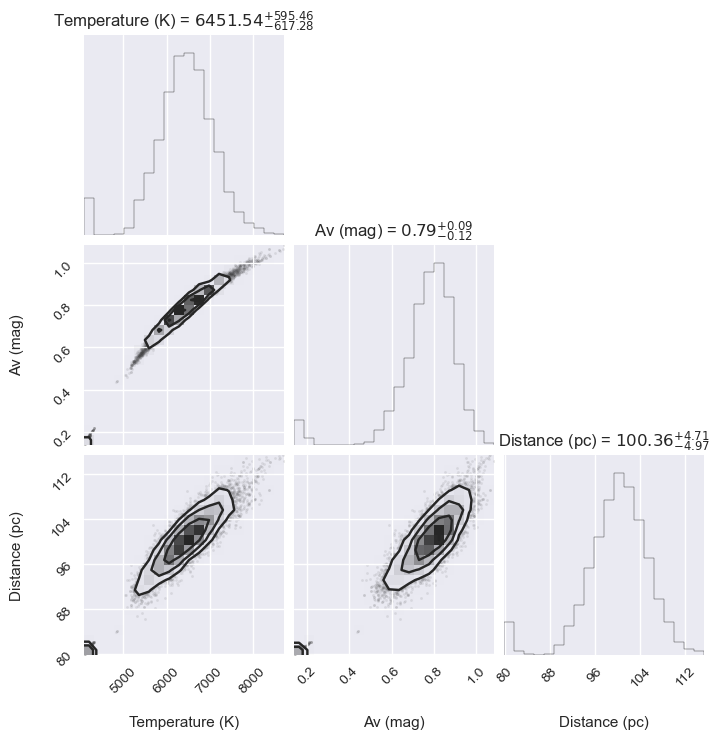

In [11]:
### YOUR ANSWER HERE

import emcee
import corner

# prior posterior functions
def log_prior(theta):
    temp, Av, dist = theta
    if 0 < temp < 15000 and 0 < Av < 5 and 0 < dist < 150:
        # Gaussian prior from ChatGPT
        return -0.5 * ((dist - 98)/5)**2 - 0.5*np.log(2*np.pi*5.0**2)
    return -np.inf

def log_posterior(theta, filter_names, m_obs, m_err):
    return log_prior(theta) - LL(theta, filter_names, m_obs, m_err)

filter_sets = {
    'All': filter_names,
    'RIJHK': ['R','I','J','H','K'],
    'BVRIJ': ['B', 'V', 'R', 'I', 'J']
}

# n walkers steps 
ndim = 3
nwalkers = 32
nsteps = 5000
burnin = 3000
thin = 10

param_labels = ['Temperature (K)', 'Av (mag)', 'Distance (pc)']

for label, names in filter_sets.items():
    mag_obs = np.array([synthetic_star[filter]['magnitude'] for filter in names])
    mag_err = np.array([synthetic_star[filter]['error'] for filter in names])
        
    # helped by ChatGPT for starting guess, otherwise the corner plot looks bad
    starting_guess = initial_guess + 1e-2 * np.array(initial_guess) * np.random.normal(size=(nwalkers, ndim))
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(names, mag_obs, mag_err))
    sampler.run_mcmc(starting_guess, nsteps, progress=True)

    chain = sampler.get_chain(discard=burnin, thin=thin, flat=True)
    
    # Get the best parameters and uncertainties
    p16  = np.percentile(chain, 16, axis=0)
    p50  = np.percentile(chain, 50, axis=0)
    p84  = np.percentile(chain, 84, axis=0)
    up_err = p84-p50
    lo_err = p50-p16
    
    print(f"{label} filters")
    print("Best MCMC Parameters:")
    for i, param in enumerate(param_labels):
        print(f"{param} = {p50[i]:.3f} +{up_err[i]:.3f}/-{lo_err[i]:.3f}")
    
    corner.corner(chain, labels=param_labels, show_titles=True)
    plt.show()

Based on the results, the MCMC results from BVRIJ filters have the closest result from the true values, which is reasonable because 6500 K is within that band. From MCMC itself, the RIJHK filters have the farthest result from the true values. In comparison to Q2 and Q3, the MCMC results for all filters have the most accurate results. 